In [1]:
!pip install openmeteo-requests requests-cache retry-requests pandas numpy matplotlib cartopy

                                              0.0/61.4 kB ? eta -:--:--
     ------                                   10.2/61.4 kB ? eta -:--:--
     -------------------------------------- 61.4/61.4 kB 825.3 kB/s eta 0:00:00
                                              0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.5 kB 1.5 MB/s eta 0:00:00


In [2]:
!pip install basemap

                                              0.0/507.3 kB ? eta -:--:--
                                              10.2/507.3 kB ? eta -:--:--
     ----                                  61.4/507.3 kB 812.7 kB/s eta 0:00:01
     -------------                          174.1/507.3 kB 1.5 MB/s eta 0:00:01
     --------------------------             358.4/507.3 kB 2.2 MB/s eta 0:00:01
     -------------------------------------- 507.3/507.3 kB 2.4 MB/s eta 0:00:00
                                              0.0/30.5 MB ? eta -:--:--
                                              0.2/30.5 MB 4.1 MB/s eta 0:00:08
                                              0.5/30.5 MB 4.7 MB/s eta 0:00:07
                                              0.7/30.5 MB 5.2 MB/s eta 0:00:06
     -                                        1.0/30.5 MB 5.3 MB/s eta 0:00:06
     -                                        1.3/30.5 MB 5.3 MB/s eta 0:00:06
     -                                        1.5/30.5 MB 5.3 MB/s

In [3]:
import openmeteo_requests
import requests_cache
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import time

# Configuração inicial para coleta de dados via Open-Meteo API
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
openmeteo = openmeteo_requests.Client(session=cache_session)

# Definir as coordenadas para o Hemisfério Sul
lons = np.arange(0, 360, 5)
lats = np.arange(-90, 0, 5)

# Dados para armazenar as velocidades do vento e geopotencial
wind_speed_250hPa = []
geopotential_height_500hPa = []

# Make sure all required weather variables are listed here
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 0,
    "longitude": 0,
    "hourly": ["windspeed_250hPa", "geopotential_height_500hPa"],
    "forecast_days": 2,
    "models": ["ecmwf_ifs04", "gfs_seamless", "gfs_global", "jma_seamless",
               "icon_seamless", "gem_seamless", "meteofrance_seamless", "arpae_cosmo_seamless"]
}

# Iterar sobre as coordenadas e solicitar os dados meteorológicos
for lon in lons:
    for lat in lats:
        # Corrigir a longitude se estiver fora do intervalo válido
        lon = lon if lon <= 180 else lon - 360

        params["latitude"] = lat
        params["longitude"] = lon

        try:
            responses = openmeteo.weather_api(url, params=params)
            response = responses[0]
            hourly = response.Hourly()

            # Armazenar dados de velocidade do vento a 250hPa
            wind_speed_250hPa.append(hourly.Variables(0).ValuesAsNumpy())

            # Armazenar dados de geopotencial a 500hPa
            geopotential_height_500hPa.append(hourly.Variables(1).ValuesAsNumpy())
        except Exception as e:
            print(f"Erro ao buscar dados para latitude {lat}, longitude {lon}: {e}")

        # Aguardar um minuto antes da próxima solicitação
        time.sleep(60)

# Criar a grade de coordenadas para o mapa
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Calcular a média das velocidades do vento e geopotencial para criar a grade
mean_wind_speed_250hPa = np.mean(wind_speed_250hPa, axis=0)
mean_geopotential_height_500hPa = np.mean(geopotential_height_500hPa, axis=0)

# Criar o mapa
plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=0, llcrnrlon=0, urcrnrlon=360, resolution='c')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90, 1, 10), labels=[1, 0, 0, 0], linewidth=0.5)
m.drawmeridians(np.arange(0, 361, 20), labels=[0, 0, 0, 1], linewidth=0.5)

# Plotar o sombreado do vento a 250hPa
xi, yi = m(lon_grid, lat_grid)
zi_wind = griddata((lon_grid.flatten(), lat_grid.flatten()), mean_wind_speed_250hPa.flatten(), (xi, yi), method='cubic')
plt.contourf(xi, yi, zi_wind, cmap='coolwarm')

# Plotar as linhas de geopotencial a 500hPa
xi, yi = m(lon_grid, lat_grid)
zi_geopotential = griddata((lon_grid.flatten(), lat_grid.flatten()), mean_geopotential_height_500hPa.flatten(), (xi, yi), method='cubic')
plt.contour(xi, yi, zi_geopotential, colors='k', levels=10)

# Adicionar barra de cores
plt.colorbar(label='Velocidade do Vento a 250hPa (m/s)')

plt.title('Mapa do Hemisfério Sul: Vento a 250hPa e Linhas de Geopotencial a 500hPa')
plt.show()


KeyboardInterrupt: 

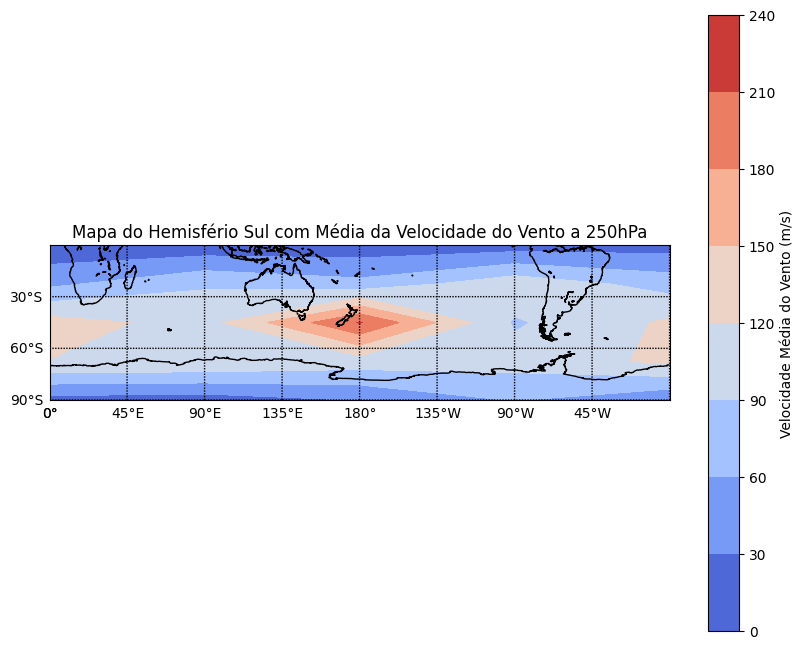

In [ ]:
import openmeteo_requests
import requests_cache
import numpy as np
import matplotlib.pyplot as plt
from retry_requests import retry
from mpl_toolkits.basemap import Basemap

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Lista de coordenadas ajustada para o hemisfério sul
locations = [(-lat, lon) for lat in [0, 30, 45, 60, 90] for lon in [0, 45, 90, 135, 180]]

# Lista para armazenar as médias da velocidade do vento em cada coordenada
mean_wind_speeds = []

# Make sure all required weather variables are listed here
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "current": "surface_pressure",
    "hourly": ["windspeed_250hPa", "geopotential_height_500hPa"],
    "forecast_days": 1,  # Apenas o primeiro dia
    "models": ["ecmwf_ifs04"]
}

# Iterar sobre as coordenadas e solicitar os dados meteorológicos
for latitude, longitude in locations:
    params["latitude"] = latitude
    params["longitude"] = longitude

    try:
        responses = openmeteo.weather_api(url, params=params)
        for response in responses:
            # Processar os dados meteorológicos
            hourly = response.Hourly()
            wind_speed_250hPa = hourly.Variables(0).ValuesAsNumpy()

            # Calcular a média da velocidade do vento em cada coordenada
            mean_wind_speed = np.mean(wind_speed_250hPa)
            mean_wind_speeds.append(mean_wind_speed)
    except Exception as e:
        print(f"Erro ao buscar dados para latitude {latitude}, longitude {longitude}: {e}")

# Plotagem do mapa
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=0, llcrnrlon=0, urcrnrlon=360, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

# Converter as médias da velocidade do vento em uma matriz 2D para plotagem de sombreado
mean_wind_speeds = np.array(mean_wind_speeds).reshape(5, 5)

# Plotagem do sombreado da média da velocidade do vento
x, y = np.meshgrid(np.linspace(0, 360, 5), np.linspace(-90, 0, 5))
m.contourf(x, y, mean_wind_speeds, cmap='coolwarm')

plt.colorbar(label='Velocidade Média do Vento (m/s)')
plt.title('Mapa do Hemisfério Sul com Média da Velocidade do Vento a 250hPa')
plt.show()


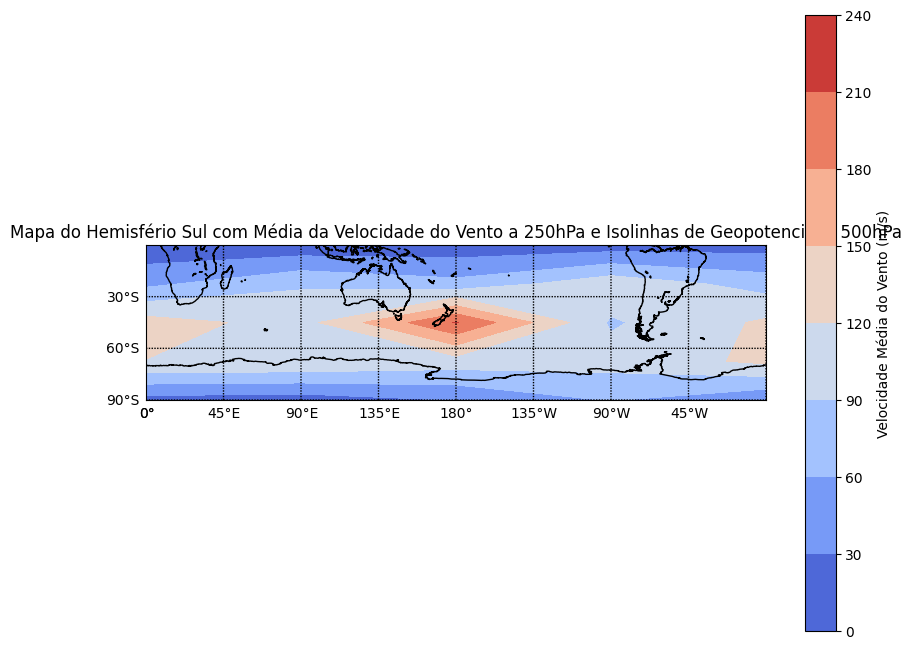

In [ ]:
import openmeteo_requests
import requests_cache
import numpy as np
import matplotlib.pyplot as plt
from retry_requests import retry
from mpl_toolkits.basemap import Basemap

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Lista de coordenadas ajustada para o hemisfério sul
locations = [(-lat, lon) for lat in [0, 30, 45, 60, 90] for lon in [0, 45, 90, 135, 180]]

# Lista para armazenar as médias da velocidade do vento em cada coordenada
mean_wind_speeds = []

# Lista para armazenar os dados de geopotencial a 500hPa em cada coordenada
geopotential_height_500hPa_data = []

# Make sure all required weather variables are listed here
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "current": "surface_pressure",
    "hourly": ["windspeed_250hPa", "geopotential_height_500hPa"],
    "forecast_days": 1,  # Apenas o primeiro dia
    "models": ["ecmwf_ifs04"]
}

# Iterar sobre as coordenadas e solicitar os dados meteorológicos
for latitude, longitude in locations:
    params["latitude"] = latitude
    params["longitude"] = longitude

    try:
        responses = openmeteo.weather_api(url, params=params)
        for response in responses:
            # Processar os dados meteorológicos
            hourly = response.Hourly()
            wind_speed_250hPa = hourly.Variables(0).ValuesAsNumpy()
            geopotential_height_500hPa = hourly.Variables(1).ValuesAsNumpy()

            # Calcular a média da velocidade do vento em cada coordenada
            mean_wind_speed = np.mean(wind_speed_250hPa)
            mean_wind_speeds.append(mean_wind_speed)

            # Adicionar dados de geopotencial a 500hPa ao dicionário
            geopotential_height_500hPa_data.append((latitude, longitude, geopotential_height_500hPa))
    except Exception as e:
        print(f"Erro ao buscar dados para latitude {latitude}, longitude {longitude}: {e}")

# Converter as médias da velocidade do vento em uma matriz 2D para plotagem de sombreado
mean_wind_speeds = np.array(mean_wind_speeds).reshape(5, 5)

# Plotagem do mapa
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=0, llcrnrlon=0, urcrnrlon=360, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

# Plotagem do sombreado da média da velocidade do vento
x, y = np.meshgrid(np.linspace(0, 360, 5), np.linspace(-90, 0, 5))
m.contourf(x, y, mean_wind_speeds, cmap='coolwarm')

plt.colorbar(label='Velocidade Média do Vento (m/s)')
plt.title('Mapa do Hemisfério Sul com Média da Velocidade do Vento a 250hPa e Isolinhas de Geopotencial a 500hPa')
plt.show()


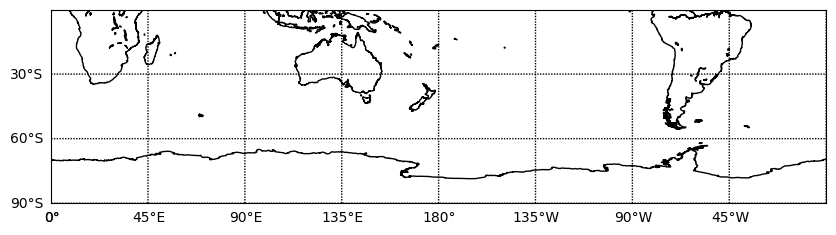

In [50]:
import sys

# Redirecionar a saída padrão para um arquivo de log
sys.stdout = open('output.log', 'w')

import %pip install requests_cache numpy retry_requests basemap matplotlib
requests_cache
import numpy as np
import matplotlib.pyplot as plt
from retry_requests import retry
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Lista de coordenadas ajustada para o hemisfério sul
locations = [(-lat, lon) for lat in [0, 30, 45, 60, 90] for lon in [0, 45, 90, 135, 180]]

# Inicializar a figura e o mapa
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=0, llcrnrlon=0, urcrnrlon=360, resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

# Função de inicialização da animação
def init():
    pass

# Função de animação para atualizar o mapa para cada dia
def animate(i):
    print(f"Plotando mapa para o dia {i + 1}...")
    # Lista para armazenar as médias da velocidade do vento em cada coordenada para o dia atual
    mean_wind_speeds = []

    try:
        params = {
            "current": "surface_pressure",
            "hourly": ["windspeed_250hPa", "geopotential_height_500hPa"],
            "forecast_days": 1,  # Apenas o dia atual
            "models": ["ecmwf_ifs04"],
            "day": i + 1
        }

        for latitude, longitude in locations:
            params["latitude"] = latitude
            params["longitude"] = longitude

            responses = openmeteo.weather_api(url, params=params)
            print(f"Resposta para latitude {latitude}, longitude {longitude}: {responses}")

            for response in responses:
                print(f"Processando resposta para latitude {latitude}, longitude {longitude}...")
                # Processar os dados meteorológicos
                hourly = response.Hourly()
                wind_speed_250hPa = hourly.Variables(0).ValuesAsNumpy()

                # Calcular a média da velocidade do vento em cada coordenada
                mean_wind_speed = np.mean(wind_speed_250hPa)
                mean_wind_speeds.append(mean_wind_speed)
    except Exception as e:
        print(f"Erro ao buscar dados para o dia {i + 1}: {e}")
        return

    # Converter as médias da velocidade do vento em uma matriz 2D para plotagem de sombreado
    mean_wind_speeds = np.array(mean_wind_speeds).reshape(5, 5)
    print(f"Médias da velocidade do vento para o dia {i + 1}: {mean_wind_speeds}")

    # Remover o conteúdo atual do mapa
    plt.gca().cla()

    # Replotar o mapa com os dados atualizados para o dia atual
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])
    x, y = np.meshgrid(np.linspace(0, 360, 5), np.linspace(-90, 0, 5))
    m.contourf(x, y, mean_wind_speeds, cmap='coolwarm')
    plt.colorbar(label='Velocidade Média do Vento (m/s)')
    plt.title(f'Mapa do Hemisfério Sul com Média da Velocidade do Vento a 250hPa (Dia {i + 1})')

# Criar a animação
ani = FuncAnimation(fig, animate, frames=16, init_func=init, blit=False)

# Exibir a animação
plt.show()
